## What is Numpy?

Numpy which stands for Numerical Python, is a library cconsisting of multidimensional array objects and a collection of routines for processing those arrays. Mathematical and logical operations can be performed using numpy. Numpy can perform 1D, 2D, 3D array operation. The most important object in numpy is defined as an N-dimensional array type called `ndarray`. `ndarray` is the collection of items of the same type and can be accessed using a zero based index.\

**Operations using Numpy:**

* Mathematical and logical operations on arrays 
* Fourier transforms and routines for shape manipulation 
* Operations related to linear algebra. Numpy has in built functions for linear algebra and random number generation.

**Now the first Question comes in mind that why we are taking numpy as for operation instead we have list?**\
**The answer is: List is very slow compared to numpy. Now that's why?** 

The first reason is Numpy arrays have a fixed size in creation, unlike Python lists (which can grow dynamically).

* Faster to read less bytes of memory 
* No type checking when iterating through objects


In the below figure you can see that the number 5 when it is readed to computer it is always converted to 8 bit binary. If you see the format of Numpy it has a fixed format of Int32 but for lists you can see dynamic type acccording to size, Reference count, Object Type, Object Value. That takes lot's of time.

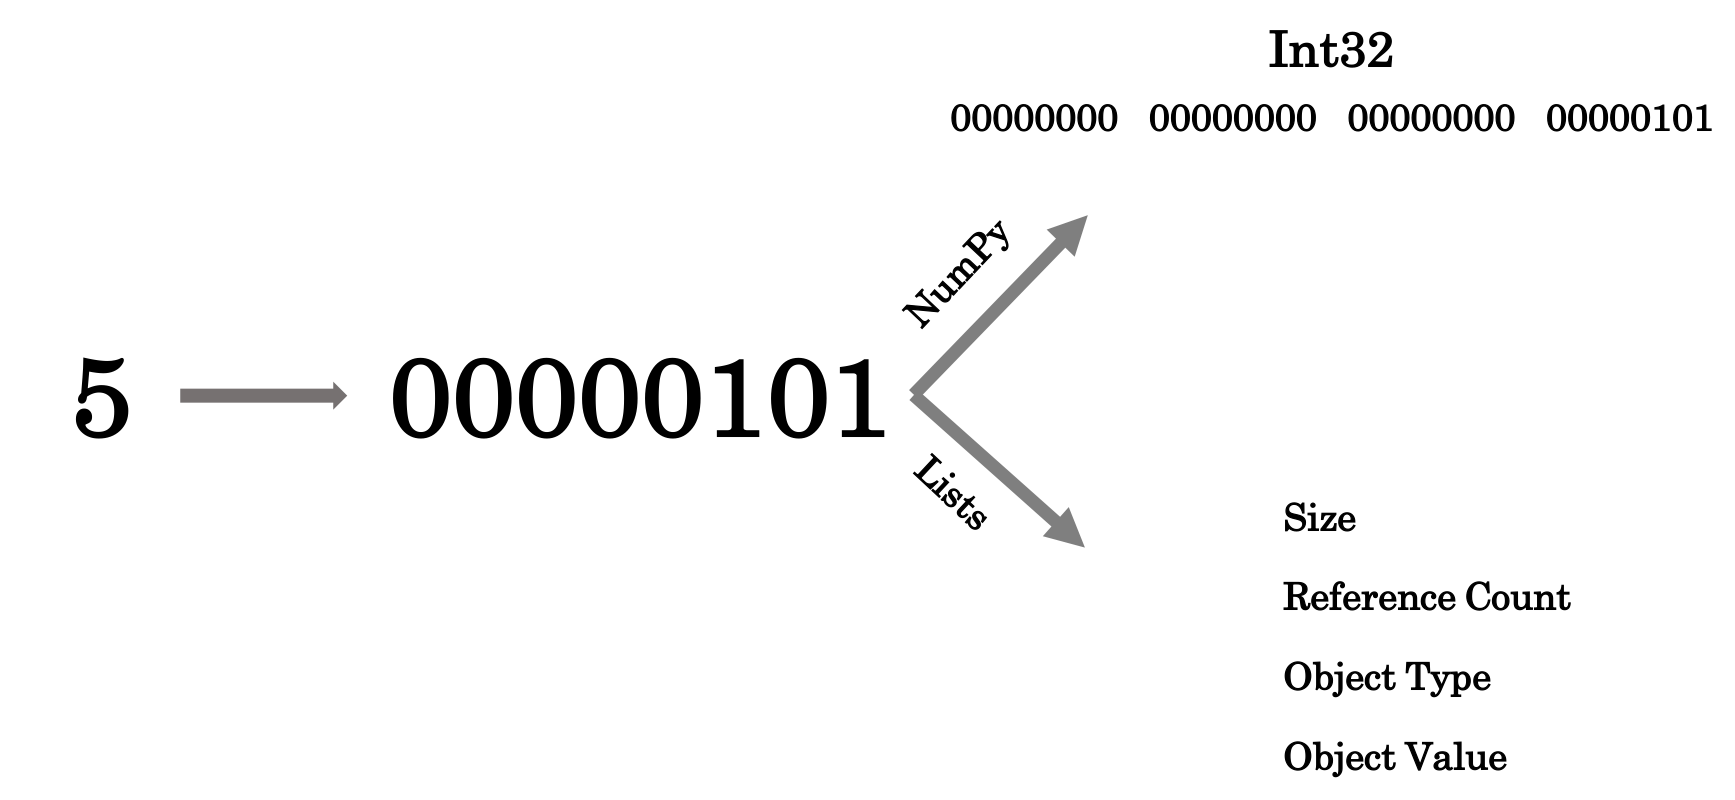

In [1]:
from IPython import display
display.Image("numpy_array.png")

### Comparing Memory Use

In [2]:
import numpy as np 
import time 
import sys 

#creating a Numpy array with 100 elements 
array = np.arange(100)
#array.itemsize: size of one element
#array.size: length of array 

print("Size of Numpy array: ", array.size*array.itemsize)

#creating a list with 100 elements 
#Now I'll print the size of list 
list_new = range(0,100)
#Multiplying size of 1 element with length of the list 
print("Size of list: ", sys.getsizeof(1)*len(list_new))

Size of Numpy array:  800
Size of list:  2800


Here you can see the total size of numpy array is 800 but the size of the list is 2800.\
This clearly indicates that Numpy array consumes less memory as compared to the python list. 

### Fast computation of numpy array

In [3]:
import numpy as np 
import time 
import sys

#declaring the size of the array 
size = 100000

#creating two list 
first_list = range(size)
second_list = range(size)

#creating two Numpy arrays 
array_1 = np.arange(size)
array_2 = np.arange(size)

#calculating time for python list 
start = time.time()
result = [(x*y) for x, y in zip(first_list, second_list)]

print("Time for Python List in msec: ", (time.time() - start) * 1000)

#calculating time for NumPy array 
start = time.time() 
result = array_1*array_2
print("Time for NumPy array in msec: ", (time.time()- start) * 1000)
print("\nThis means NumPy array is faster than Python List")

Time for Python List in msec:  17.544031143188477
Time for NumPy array in msec:  5.785703659057617

This means NumPy array is faster than Python List


We can see that numpy is 2 times faster than list. Because the **Numpy** array is densely packed in memory due to its homogeneous type, it aalso frees the memory **faster**. So overall a task executed in **Numpy** is around 5 to 100 times **faster** than the standard **python** list, which is a significant leap in terms of speed.

## Understanding the internals of Numpy

So we have already seen that numpy is faster than list(we can say native python code), particularly when our computation follow the Single Instruction, Multiple Data (SIMD) paradigm. Here we will learn to write some optimized numpy code by understanding the internals:

### Setting up

First, we need to set few functions to check whether two arrays share the same underlying data buffer in the memory. here we will define a function aid() that will returns the memory location of underlying data buffer.

**NOTE: DATA BUFFER IS A REGION OF A PHYSICAL MEMORY STORAGE UDED TO TEMPORARILY STORE DATA WHILE IT IS BEING MOVED FROM ONE PLACCE TO ANOTHER (SIMPLY RAM).**

In [4]:
import numpy as np
def aid(x):
    # This function returns the memory
    # block address of an array.
    return x.__array_interface__['data'][0]

In [5]:
a = np.zeros(3)
aid(a), aid(a[1:])

(140227416215888, 140227416215896)

Here you can see two shared arrays but with different **offset** having slightly different memory location.

We will need a more general and reliable solution for finding out whether two arrays share the same data, Michael Droettboom created this update:

In [6]:
def get_data_base(arr):
    """For a given NumPy array, find the base array
    that owns the actual data
    """
    base = arr
    while isinstance(base.base, np.ndarray):
        base = base.base
    return base

def arrays_share_data(x,y):
    return get_data_base(x) is get_data_base(y)

print(arrays_share_data(a, a.copy()))
print(arrays_share_data(a, a[:1]))   

False
True


### How to do it ?

Computations with NumPy arrays may involve internal copies between blocks of memory. These copies are not always necessary, in which case they should be avoided, as we will see in the following tips:

1. We may sometimes need to make a copy of an array; for instance, if we need to manipulate an array while keeping an original copy in memory:

In [7]:
import numpy as np
a = np.zeros(10)
ax = aid(a)
ax

b = a.copy()
aid(b) == ax

False

2. Array computations can involve in place operations(the first example in the following code: the array is modified) or implicit-copy operations(the second example: a new array is created):

In [8]:
a *= 2
aid(a) == ax

True

In [9]:
c = a * 2
aid(c) == ax

False

Implicit-copy operations are slower, as shown here:

In [10]:
%%timeit a = np.zeros(10000000)
a *= 2

5.77 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit a = np.zeros(10000000)
b = a * 2

18.8 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


3. Reshaping an array may or may not involve a copy. For instance, reshaping a 2D matrix does not involve a copy, unless it is transposed (or more generally, **non-contiguous**):

In [12]:
a = np.zeros((100,100))
ax = aid(a)

b = a.reshape((1,-1))
aid(b) == ax

True

In [13]:
c = a.T.reshape((1,-1))
aid(c) == ax

False

In [14]:
#therefore, the transposed operation is significantly slower than the general reshape

%timeit b = a.reshape((1,-1))

348 ns ± 4.05 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
%timeit a.T.reshape((1,-1))

6.48 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


4. Both the `flatten()` and the `ravel()` methods of an array reshape it into a 1D vector (a flattened array). However, the `flatten()` method always returns a copy, and the `ravel()` method returns a copy only if necessary (thus it's faster, especially with large arrays).

In [16]:
d = a.flatten()
aid(d) == ax

False

In [17]:
e = a.ravel()
aid(e) == ax

True

In [18]:
%timeit a.flatten()

3.45 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
%timeit a.ravel()

243 ns ± 9.34 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


5. `Broadcasting rules` allow us to make computations on arrays with different but compatible shapes. In other words, we don't always need to reshape or tile our arrays to make their shapes match. The following example illustrates two ways of doing an outer product between two vectors: the first method involves array tiling, the second one (faster) involves broadcasting:

In [20]:
n = 1000
a = np.arange(n)
a_column = a[:,np.newaxis] #column vector 
a_row = a[np.newaxis, :] #row vector

%timeit np.tile(a_column,(1,n)) * np.tile(a_row,(n,1))

6.95 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit a_row * a_column

1.6 ms ± 77.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Why Numpy arrays are efficient? 

From the example we have seen several practical example of numpy arrays being efficient. Now you can see a numpy array is basically described by metadata and the actual data. The data is stored in a homogenous and contiguous block of memory at a particular address in a system memory. This block of memory is called the data buffer. This is the main difference between an array and a pure Python structure, such as a list, where the items are scattered across the system memory. This aspect is the critical feature that makes NumPy arrays so efficient.

How **NumPy** is so important:

* Computations on arrays can be written very efficiently in a low-level language such as C (and a large part of NumPy is actually written in C). Knowing the address of the memory block and the data type, it is just simple arithmetic to loop over aall items. 

* Spatial locality in memory access patterns ressults in performance gains notably due to the CPU cache. Indeed, the cache loads bytes in cchunks from RAM to the CPU registers. Adjacent items are then loaded very efficiently.

* Finally, the fact that items are stored contiguously in memory allows NumPy to take advantage of vectorized instructions of modern CPUs.

## Practical Example of Numpy with Exercise

So, starting with the basics. We will see how to call a numpy array.

In [22]:
a = np.array([1,2,3], dtype = "int16")
print(a)

[1 2 3]


In [23]:
#calling a 2 dimensional numpy array 
b = np.array([[9.0,8.0,3.4], [5.3,6.4,4.3]])
print(b)

[[9.  8.  3.4]
 [5.3 6.4 4.3]]


so, now if we want to get information about these numpy array we can know about their dimensions, shape, type with the following commands.

In [24]:
#dimension of a 
a.ndim

1

In [25]:
#dimension of b
b.ndim

2

In [26]:
#shape of a
a.shape

(3,)

In [27]:
#shape of b
b.shape

(2, 3)

In [28]:
#get itemsize 
a.itemsize #as a is int16 that means 2 bytes 

2

In [29]:
#itemsize of b
b.itemsize #as the datatype of b is float64 we can see that there are total 8 bytes - 64 bits 

8

In [30]:
#Get total size 
a.size * a.itemsize

6

In [31]:
#or we can use nbytes 
a.nbytes

6

### Accessing/Changing specific elements, rows and columns

**2D Array example**

In [32]:
#calling an array 
a = np.array([[1,2,3,4,5,6,7],[8,9,10,11,12,13,14]])
a

array([[ 1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14]])

In [33]:
#Get a specific element [row,column]
a[1,5]

13

In [34]:
#Get a specific row
a[0,:]

array([1, 2, 3, 4, 5, 6, 7])

In [35]:
#Get the specific column 
a[:, 2]

array([ 3, 10])

In [36]:
#Getting little more fancy [startindex:endindex:stepsize]
a[0,1:-1:2]

array([2, 4, 6])

In [37]:
a[1,5] = 20
print(a)

[[ 1  2  3  4  5  6  7]
 [ 8  9 10 11 12 20 14]]


In [38]:
#now suppose you want to change elements of a specific column

a[:,2] = [1,2]
print(a)

[[ 1  2  1  4  5  6  7]
 [ 8  9  2 11 12 20 14]]


**3D Array Example**

In [39]:
b = np.array([[[1,2],[3,4],[5,6],[7,8]]])
print(b)

[[[1 2]
  [3 4]
  [5 6]
  [7 8]]]


In [40]:
#Get specific element
b[0,1,1]

4

**Replacing the column of an array by the column of another array**

**1st case: If arrays are of same size**

In [41]:
n = np.zeros((2,4))

In [42]:
n

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [43]:
n[:,1] = b[:,2]

In [44]:
n

array([[0., 5., 0., 0.],
       [0., 6., 0., 0.]])

**2nd case: If arrays are of different sizes (N rows > M rows)
Let's try to replace column (1) of an N array by the column (2) of the M array:**

In [45]:
import numpy as np
M = np.array([[2,7,1],[3,3,1],[5,4,3],[0,1,8]])
M

array([[2, 7, 1],
       [3, 3, 1],
       [5, 4, 3],
       [0, 1, 8]])

In [46]:
N = np.zeros((8,6))

In [47]:
M_dim_1 = M.shape[0]
N_dim_1 = N.shape[0]

In [48]:
M_dim_1

4

In [49]:
N_dim_1

8

In [50]:
if N_dim_1 > M_dim_1:
    N[:M_dim_1,1] = M[:,2]

In [51]:
N

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0.],
       [0., 8., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

**2nd case: If arrays are of different sizes (N rows < M rows)
Let's try to replace column (1) of an N array by the column (2) of the M array:**

In [53]:
N = np.zeros((3,6))
N_dim_1 = N.shape[0]
N_dim_1

if N_dim_1 < M_dim_1:
    N[:,1] = M[:N_dim_1,2]
N

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0.]])

### Initializing Different Kind of arrays


In [54]:
#All zeros matrix
#one dimensional
np.zeros(5) #it will give you a vector of having 5 zeros

array([0., 0., 0., 0., 0.])

In [56]:
#two dimensional matrix
np.zeros((2,3)) #here the output is 2 rows and 3 columns

array([[0., 0., 0.],
       [0., 0., 0.]])

In [57]:
#all ones matrix 
np.ones((3,3,2)) #matrix of 3(section) by 3(rows) by 2(columns)
#I am calling one whole row as a section here we can see inside of the first row there is another 3 rows this is the main theme
#theme of 3 dimensional matrix

array([[[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.]]])

In [58]:
#Any other number 
np.full((2,2), 10) #2(rows) * 2(columns) matrix

array([[10, 10],
       [10, 10]])

In [59]:
np.random.rand(4,2) #4*2 matrix of random numbers

array([[0.40898744, 0.69861099],
       [0.24401292, 0.75504442],
       [0.03388764, 0.8307221 ],
       [0.83060557, 0.54428842]])

In [60]:
a = np.array([[1,2,3,4,5,6,7],[8,9,10,11,12,13,14]])

In [66]:
a.shape

(2, 7)

In [65]:
np.random.random_sample(a.shape) #a has shape of 2 rows and 7 columns

array([[0.17591206, 0.31342436, 0.28566402, 0.27219869, 0.18310555,
        0.81564417, 0.49739888],
       [0.81579752, 0.34141546, 0.90007451, 0.91582801, 0.31678797,
        0.53619679, 0.53019654]])

In [64]:
#Random integer values
np.random.randint(7, size = (3,3))

array([[4, 0, 4],
       [1, 5, 5],
       [1, 6, 1]])

In [67]:
#creating identity matrix
np.identity(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

### Array copy

In [68]:
a = np.array([1,2,3])
b = a
b[0] = 19

In [69]:
print(a)#so here we can see the issue that our core array value has changed. So if we want to prevent that.

[19  2  3]


In [70]:
a = np.array([1,2,3])
b = a.copy()
b[0] = 19

In [71]:
print(a) #the actual array hasn't changed
print(b) #this one is the copyed one 

[1 2 3]
[19  2  3]


## Slicing

**var[lower:upper:step]**\
Extract a portion of a sequence by specifying a lower and upper bound. The lower bound element is included, but the upper bound element is not included. 

**Slicing Arrays**

In [73]:
a = np.array([10,11,12,14,15])
a

array([10, 11, 12, 14, 15])

In [75]:
a[1:3] #from 1 to 3 that means 1 and 2

array([11, 12])

In [76]:
#negative indices can work as well.
a[1:-2]

array([11, 12])

In [77]:
a[-4:3]

array([11, 12])

In [78]:
#grabbing the first three indices
a[:3]

array([10, 11, 12])

In [79]:
#grabbing last two elements
a[-2:]

array([14, 15])

In [80]:
#every other element 
a[::2]

array([10, 12, 15])

**Slicing in multidimensional Array**

In [81]:
#creating a multidimensional array
a = np.arange(25).reshape(5,5) #so here np.arange(25) is creating an array of 0-24 numbers then reshape is making it a square
#or a 5*5 rectangular matrix if we say.

In [82]:
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [85]:
#now if i want to extract 1,6,11,16,21 and 3,8,13,18,23
#so for the solution we need all the rows but selective columns
a[:,1::2] #here all the rows are selected first then setting the offset as 1 and then select every other column till 2

array([[ 1,  3],
       [ 6,  8],
       [11, 13],
       [16, 18],
       [21, 23]])

In [87]:
#now if we want to extract 20,21,22,23,24 from the array 
a[4, :] #this is better to write but you can write a[4] too but there the information will be missing that you are 
#working with a multidimensional array

array([20, 21, 22, 23, 24])

In [88]:
a[-1,:] #same as previous

array([20, 21, 22, 23, 24])

In [90]:
#now let's do little bit complex work. So if we want to get 5,7,15,17
a[1::2, :3:2] #so here we want all the rows of 1 and 2 and then we will start the column from 1,3,5(2 step at once).And
#we can stop in 3rd step or 4th step or -1 step. It will give us same output.

array([[ 5,  7],
       [15, 17]])

In [92]:
a[1::2, :4:2]

array([[ 5,  7],
       [15, 17]])

In [93]:
a[1::2, :-1:2]

array([[ 5,  7],
       [15, 17]])

## Exercise using a image (Slicing Exercise)

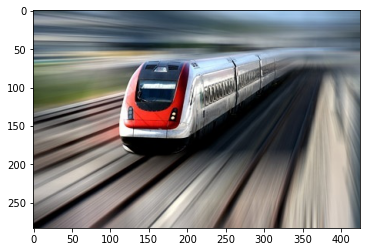

In [94]:
"""
Filter Image
-------------

Read in the "metro_image" image and use an averaging filter to "smooth" the image. Use a "5 point stencil" where you average
the current pixel witth its neighboring pixels

                           0 0 0 0 0 0 0
                           0 0 0 X 0 0 0
                           0 0 X X X 0 0
                           0 0 0 X 0 0 0
                           0 0 0 0 0 0 0
plot the image, the smoothed image, and the ddifference betweern two.
"""

import matplotlib.pyplot as plt
img = plt.imread('metro_image.jpg')
#top = img[0:2, 1:3]
#left = img[1:3, 0:2]
#blurred = (top + left)/5
plt.imshow(img, cmap = plt.cm.hot)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'difference')

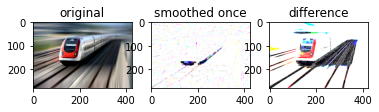

In [95]:
#solution 
import numpy as np
import matplotlib.pyplot as plt

def smooth(img):
    average_image =(
        img[1:-1, 1:-1] #center
        + img[:-2, 1:-1] #top
        + img[2:,1:-1]  # bottom
        + img[1:-1, :-2]  # left
        + img[1:-1,2:  ]  # right
    ) / 5.0
    return average_image

average_image = smooth(img)
plt.figure()
# Set colormap so that images are plotted in gray scale.
plt.gray()
# Plot the original image first
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('original')

# Now the filtered image.
plt.subplot(1,3,2)
plt.imshow(average_image)
plt.title('smoothed once')

# And finally the difference between the two.
plt.subplot(1,3,3)
plt.imshow(img[1:-1,1:-1] -average_image)
plt.title('difference')